In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from laguerre_basis import *
from sim_data import *
from compute_V import *
from cholesky_decomp import *
from ForwardFiniteDifference import *
from Compute_fIRF_CLSD_LE import *
print("Done importing")

Done importing


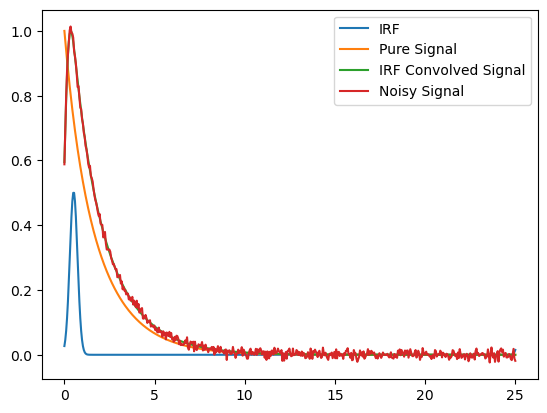

In [3]:
##Simulate data test
irf, t = gaussian_irf(40,512,0.5)
sig, t = gen_signal(40, 512, (0.2,0.8), (0.8,2)) # generate two component decay 
sig_irf, t = gen_signal(40, 512, (0.2, 0.8), (0.8, 2), irf) # generate decay with irf
sig_noisy = add_white_noise(sig_irf, 20) # add white noise at 20 db

#shift and scale irf for nice display:
nonZeroIdx = np.argmin(np.abs(irf[:int(len(irf)/2)] - 1/20))
irf = 0.5 * np.roll(irf, -nonZeroIdx)

plt.plot(t * 10**9, irf, label="IRF")
plt.plot(t * 10**9, sig, label="Pure Signal")
plt.plot(t * 10**9, sig_irf, label = "IRF Convolved Signal")
plt.plot(t * 10**9, sig_noisy, label = "Noisy Signal")
plt.legend()
plt.show()

In [5]:
#Get C, V, D, 
#cost function is ||C{V.T@y-D.T@lambda}||^2
N=t*10**9
alpha = 0.8
L = 12
iirf = irf
V = compute_V(len(N), alpha, L, iirf)
V_V_T_inv = np.linalg.inv(V.T@V)
C = compute_cholesky(V_V_T_inv)
FFD3 = Compute_ForwardFiniteDiff(L,len(N),alpha)
print("Done Computing")

Done Computing


In [7]:
#Perform the minimization with built in optimizer
lmbda = np.zeros(len(FFD3))
lmbda_min = CLSD_minimize(lmbda,C,V,sig_irf, FFD3)

# Output results
if lmbda_min.success:
    #print("Optimal lambda:", lmbda_min.x)
    print(lmbda_min.x.shape)
    print("Minimum objective function value:", lmbda_min.fun)
else:
    print("Optimization failed:", lmbda_min.message)

(509,)
Minimum objective function value: 103.95747820403159


In [9]:
#Find coefficents based off optimized lambda
C_cls=compute_Ccls(V,C,FFD3,lmbda_min,sig_irf) #constrained least squares coefficients'
print("Got coefficients")

Got coefficients


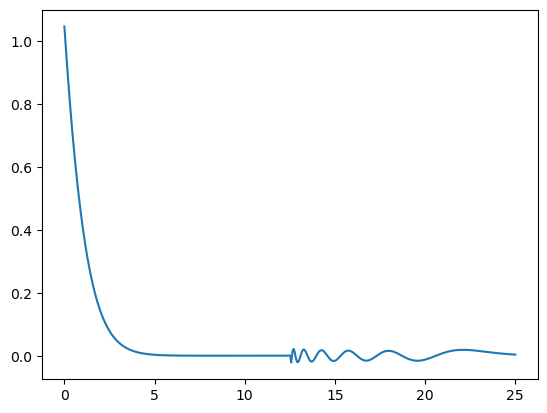

In [11]:
#compute the fIRF
h_fIRF = ComputefIRF(C_cls, len(N), alpha, L)

#convolve with the irf function
output_response = np.convolve(iirf, h_fIRF, mode = 'same')
plt.plot(t*10**9,output_response, label = "Output Response")
#plt.savefig('cls.png')
plt.show()